In [54]:
# Essential imports
from __future__ import annotations

import numpy as np
import networkx as nx

from graphix import Circuit, Statevec, Pattern, command
from graphix.pauli import Pauli
from graphix.ops import Ops
from graphix.states import BasicStates
import graphix.instruction as instruction
from graphix.fundamentals import Plane

import mentpy as mp

## Testing Mentpy

(<Figure size 800x300 with 1 Axes>, <Axes: >)

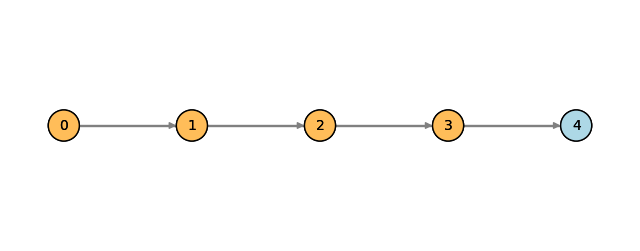

In [55]:
gs = mp.GraphState()
gs.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 4)])
mbcirc = mp.MBQCircuit(gs, input_nodes=[0], output_nodes=[4])
mp.draw(mbcirc)

(<Figure size 800x300 with 1 Axes>, <Axes: >)

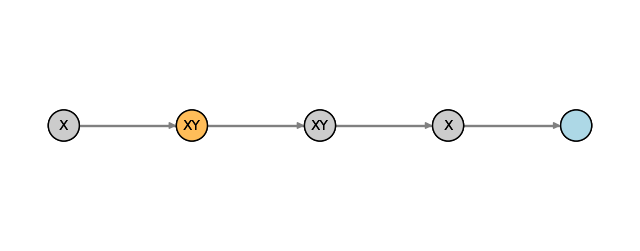

In [56]:
mbcirc[0] = mp.Ment('X')
mbcirc[1] = mp.Ment('XY')
mbcirc[2] = mp.Ment(0.5, 'XY')
mbcirc[3] = mp.Ment('X')
mp.draw(mbcirc, label='planes')

(<Figure size 800x300 with 1 Axes>, <Axes: >)

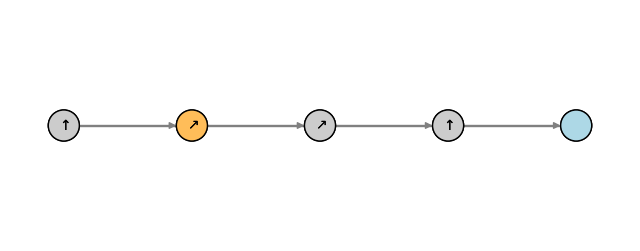

In [57]:
measurements = {0: mp.Ment('X'), 1: mp.Ment('XY'), 2: mp.Ment(0.5, 'XY'), 3: mp.Ment('X')}
mbcirc = mp.MBQCircuit(gs, input_nodes=[0], output_nodes=[4], measurements=measurements)
mp.draw(mbcirc, label='arrows')

In [58]:
mbcirc = mp.MBQCircuit(gs, input_nodes=[0], output_nodes=[4],
                     measurements={1: mp.Ment('XY')},
                     default_measurement=mp.Ment('X'))
print(mbcirc[0]) # Not specified in the constructor
print(mbcirc[1]) # Specified in the constructor
print(mbcirc[2].matrix()) # Matrix of the measurement operator

Ment(0, X)
Ment(θ, XY)
[[0 1]
 [1 0]]


(<Figure size 800x300 with 1 Axes>, <Axes: >)

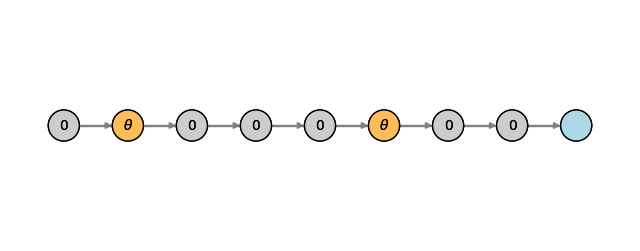

In [59]:
new_circ = mp.merge(mbcirc, mbcirc, along=[(4,0)])  # specify nodes to merge
mp.draw(new_circ, label='angles')

(<Figure size 800x300 with 1 Axes>, <Axes: >)

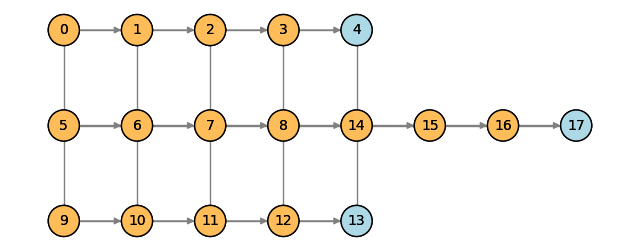

In [60]:
grid_cluster = mp.templates.grid_cluster(3, 5)
linear_cluster = mp.templates.linear_cluster(4)
grid_and_linear = mp.merge(grid_cluster, linear_cluster, along=[(9,0)])
mp.draw(grid_and_linear)

## Lie algebra part

In [61]:
ops = mp.utils.calculate_lie_algebra(grid_cluster)
print(len(ops))
ops[:3]

64


IIZ
IIX
IXZ

In [62]:
# calculate_lie_algebra breaks down into calculating the generators of the algebra (calculate_gens)
# and then completing the algebra (lie_algebra_completion).

gens = mp.utils.calculate_gens(grid_cluster)
print(gens)


IIZ
IIX
IXZ
XZI
IZI
IXI
XZX
ZXZ
ZII
XII
ZXI
IZX


In [63]:
# Generators are calculated and a subset for the output nodes is selected.
# What is needed for the generators:
# - Flow for the graph state
# - "Trainable nodes" (what nodes have not been allocated a measurement angle)
# - Function to calculate generating operator for a node (either the measurement operator or some power of it)
# - Collection of these for all "trainable nodes" is the complete generating set
# - I don't quite understand the calculation of the generating operator for a node yet **

## Testing with Graphix

In [81]:
"""Graphix interface for the MentPy package.

Copyright (C) 2025, QAT team (ENS-PSL, Inria, CNRS).

ref: MentPy: A Python package for parametrized MBQC circuits
Mantilla Calderón, Luis
https://github.com/mentpy/mentpy
"""
from __future__ import annotations

import networkx as nx
from graphix import Pattern, command
from graphix.fundamentals import Plane
from graphix.gflow import find_flow, find_gflow
from graphix.measurements import Measurement
from graphix.opengraph import OpenGraph
from graphix.parameter import Expression, ExpressionOrFloat
from graphix.pauli import Pauli

import mentpy as mp


def graphix_pattern_to_mentpy(pattern: Pattern) -> mp.MBQCircuit:
    """Convert a Graphix pattern to a MentPy MBQCircuit.

    Parameters
    ----------
    pattern: graphix.Pattern

    Returns
    -------
    result: mentpy.MBQCircuit

    Exceptions
    ---------
    NotImplementedError
        If the pattern has Expression measurements not supported by MentPy

    ValueError
        If the pattern has no flow or gflow.

    """  # noqa: DOC501
    nodes, edges = pattern.get_graph()
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    vin = pattern.input_nodes if pattern.input_nodes is not None else []
    vout = pattern.output_nodes
    measurements: dict[int, mp.Ment] = {}
    meas_planes = pattern.get_meas_plane().items()
    meas_angles = pattern.get_angles()
    if any(isinstance(angle, Expression) for angle in meas_angles):
        msg = "MentPy doesn't support Expression measurements."
        raise NotImplementedError(msg)
    for i, plane in enumerate(meas_planes):
        plane_str = str(plane[1]).split(".")[1]  # convert to 'XY', 'YZ', or 'XZ' strings
        if i in vout:
            continue
        angle = float(meas_angles[i]) # type: ignore
        measurements[i] = mp.Ment(angle, plane_str) # type: ignore
    flow = find_flow(g, set(vin), set(vout), meas_planes=pattern.get_meas_plane())[0]
    g_flow = find_gflow(g, set(vin), set(vout), meas_planes=pattern.get_meas_plane())[0]
    if not (flow or g_flow):
        msg = "No flow or gflow found, cannot convert to MBQCircuit."
        raise ValueError(msg)
    graph_state: mp.GraphState = mp.GraphState(g)  # type: ignore
    return mp.MBQCircuit(graph_state, input_nodes=vin, output_nodes=vout, measurements=measurements)


def mentpy_to_graphix_pattern(graph_state: mp.MBQCircuit) -> Pattern:
    """Convert a MentPy MBQCircuit to a Graphix pattern.

    Parameters
    ----------
    graph: mentpy.MBQCircuit

    Returns
    -------
    result: graphix.Pattern

    """
    conversion_dict = {"XY": Plane.XY, "YZ": Plane.YZ, "XZ": Plane.XZ}
    measurements: dict[int, Measurement] = {}
    for index, measurement in graph_state.measurements.items():
        if measurement is not None:
            angle = measurement.angle if isinstance(measurement.angle, ExpressionOrFloat) else 0.0
            measurements[index] = Measurement(angle, conversion_dict[measurement.plane])
    open_graph = OpenGraph(graph_state.graph, measurements, graph_state.input_nodes, graph_state.output_nodes)
    return open_graph.to_pattern()


def _mentpy_pauli_to_graphix_pauli(generators: list[mp.operators.pauliop.PauliOp]) -> list[list[Pauli]]:
    """Convert a list of MentPy Pauli operators into Graphix format.

    Parameters
    ----------
    generators: list[mentpy.operators.pauliop.PauliOp]
        List of MentPy Pauli operators

    Returns
    -------
    result: list[list[Pauli]]
        List of list of Graphix Pauli operators

    Raises
    ------
    ValueError
        If the element is not a Pauli

    """
    output_generator_list = []
    for generator in generators:
        output_generator = []
        generator_as_list = list(str(generator))
        for pauli in generator_as_list:
            if str(pauli) == "X":
                output_generator.append(Pauli.X)
            elif str(pauli) == "Y":
                output_generator.append(Pauli.Y)
            elif str(pauli) == "Z":
                output_generator.append(Pauli.Z)
            elif str(pauli) == "I":
                output_generator.append(Pauli.I)
            else:
                msg = "The element is not a Pauli"
                raise ValueError(msg)
        output_generator_list.append(output_generator)
    return output_generator_list


def calculate_lie_algebra(pattern: Pattern) -> list[list[Pauli]]:
    """Calculate the Lie algebra for a Graphix MBQC pattern using MentPy utils.

    Parameters
    ----------
    pattern: Pattern
        Pattern from Graphix

    Returns
    -------
    result: list[list[Pauli]]
        List of list of Graphix Pauli gates

    """
    mp_pattern = graphix_pattern_to_mentpy(pattern)
    if mp_pattern.trainable_nodes is None:
        raise ValueError("The pattern is not trainable.")
    lie_algebra = mp.utils.calculate_lie_algebra(mp_pattern)
    return _mentpy_pauli_to_graphix_pauli(lie_algebra)


In [82]:
def fx_rng(fx_bg: PCG64) -> Generator:
    """Fixture for generator.

    Returns
    -------
        Generator

    """
    return Generator(fx_bg)

In [84]:
from mentpy.utils.lie_algebra import calculate_complete_gens
import pytest
from numpy.random import PCG64, Generator
SEED = 25

TEST_BASIC_CIRCUITS = [
    Circuit(2, instr=[instruction.H(0), instruction.CNOT(0, 1)]),
    Circuit(2, instr=[instruction.S(0), instruction.CNOT(0, 1)]),
    Circuit(2, instr=[instruction.X(0), instruction.CNOT(0, 1)]),
    Circuit(2, instr=[instruction.Y(0), instruction.CNOT(0, 1)]),
    Circuit(2, instr=[instruction.Z(0), instruction.CNOT(0, 1)]),
    Circuit(2, instr=[instruction.RX(0, np.pi / 4), instruction.CNOT(0, 1)]),
    Circuit(2, instr=[instruction.RY(0, np.pi / 4), instruction.CNOT(0, 1)]),
    Circuit(2, instr=[instruction.RZ(0, np.pi / 4), instruction.CNOT(0, 1)]),
    Circuit(2, instr=[instruction.CNOT(0, 1), instruction.CNOT(0, 1)]),
    Circuit(3, instr=[instruction.CCX(0, (1, 2))]),
]

def regenerate_pattern_from_og(pattern: Pattern) -> Pattern:
    """Regenerate pattern from Open Graph through flow-finding algorithm."""
    og_from_pattern = OpenGraph.from_pattern(pattern)
    return og_from_pattern.to_pattern()

circuit = TEST_BASIC_CIRCUITS[9]
pattern = circuit.transpile().pattern
pattern_to_mentpy = graphix_pattern_to_mentpy(pattern)
pattern_og = regenerate_pattern_from_og(pattern)
pattern.standardize()
pattern.shift_signals()
pattern_og.standardize()
pattern_og.shift_signals()
print(pattern.get_measurement_commands())
print(pattern_og.get_measurement_commands())
pattern_to_and_from_mentpy = mentpy_to_graphix_pattern(pattern_to_mentpy)
pattern_to_and_from_mentpy.standardize()
pattern_to_and_from_mentpy.shift_signals()
print(pattern_to_and_from_mentpy.get_measurement_commands())


state_mbqc = pattern.simulate_pattern(rng=np.random.default_rng(SEED))
pattern_to_and_from_mentpy_mbqc = pattern_to_and_from_mentpy.simulate_pattern(rng=np.random.default_rng(SEED))
assert np.abs(np.dot(state_mbqc.flatten().conjugate(), pattern_to_and_from_mentpy_mbqc.flatten())) == pytest.approx(1)

[M(0), M(3, s_domain={0}), M(4, s_domain={3}), M(1), M(5, angle=-1.75, s_domain={0, 4}), M(17, s_domain={1}), M(6, s_domain={3, 5}), M(8, angle=-0.25, s_domain={0, 17, 4, 6}), M(2, angle=-0.25), M(9, s_domain={8, 3, 5}), M(12, s_domain={8, 2, 5}), M(10, angle=-1.75, s_domain={0, 4, 6, 9, 17}), M(13, angle=-1.75, s_domain={17, 12}), M(7, angle=-0.25, s_domain={17}), M(11, s_domain={8, 10, 3, 5}), M(14, s_domain={8, 2, 5, 13}), M(15, angle=-0.25, s_domain={0, 4, 6, 9, 11}), M(19, s_domain={1, 2, 5, 7, 8, 10, 13})]
[M(0), M(3, s_domain={0}), M(1), M(4, s_domain={3}), M(17, s_domain={1}), M(5, angle=-1.75, s_domain={0, 4}), M(6, s_domain={3, 5}), M(8, angle=-0.25, s_domain={0, 17, 4, 6}), M(2, angle=-0.25), M(9, s_domain={8, 3, 5}), M(12, s_domain={8, 2, 5}), M(10, angle=-1.75, s_domain={0, 4, 6, 9, 17}), M(13, angle=-1.75, s_domain={17, 12}), M(11, s_domain={8, 10, 3, 5}), M(7, angle=-0.25, s_domain={17}), M(19, s_domain={1, 7, 8, 10, 13}), M(14, s_domain={8, 2, 5, 13}), M(15, angle=-0.25